# Qamomile Quickstart Guide

This guide will help you get started with Qamomile quickly, covering installation and basic usage.

## Installation

### Prerequisites
Before installing Qamomile, ensure you have the following:

- Python 3.10 or higher
- pip (Python package installer)

### Installing Qamomile

Install Qamomile using pip:

```bash
pip install qamomile
```

### Optional Dependencies

Depending on your needs, you might want to install additional packages:

- For Qiskit integration: `pip install "qamomile[qiskit]"`
- For Quri Parts integration: `pip install "qamomile[quri-parts]"`
- For Qutip integration: `pip install "qamomile[qutip]"`
- For PennyLane integration: `pip install "qamomile[pennylane]"`

## Basic Usages

Let's walk through a simple example to demonstrate how to use Qamomile.

### 1. Import Qamomile and JijModeling

In [1]:
import qamomile.core as qm
import jijmodeling as jm
import ommx.v1

### 2. Create a Mathematical Model with JijModeling

In [2]:
# Simple QUBO

Q = jm.Placeholder("Q", ndim=2)
n = Q.len_at(0, latex="n")
x = jm.BinaryVar("x", shape=(n,))

problem = jm.Problem("qubo")
i, j = jm.Element("i", n), jm.Element("j", n)
problem += jm.sum([i, j], Q[i, j] * x[i] * x[j])

problem

In [3]:
# Prepare data
instance_data = {
    "Q": [[0.1, 0.2, -0.1],
          [0.2, 0.3, 0.4],
          [-0.1, 0.4, 0.0]]
}

# Compile the problem:
# Substitute the data into the problem.
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem)

### 3. Create a Quantum Circuit and a Hamiltonian with Qamomile

In [4]:
qaoa_converter = qm.qaoa.QAOAConverter(instance)

# Encode to Ising Hamiltonian
qaoa_converter.ising_encode()

# Get the QAOA circuit
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=2)
# Get the cost Hamiltonian
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

### 4. Transpile to a Quantum Computing SDK (Qiskit or Quri Parts)
In this example, we will use Qiskit.

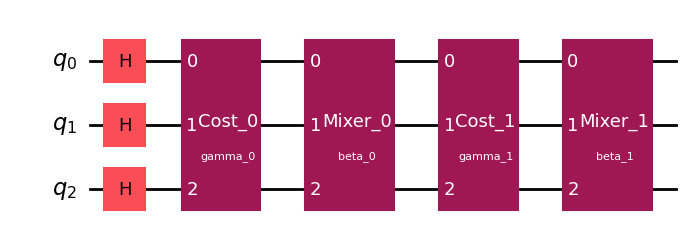

In [5]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()

# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_circuit.draw(output="mpl")

In [6]:
# Transpile the QAOA Hamiltonian to Qiskit
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIZ', 'IZI', 'ZII', 'IZZ', 'ZIZ', 'ZZI', 'III'],
              coeffs=[-0.1 +0.j, -0.45+0.j, -0.15+0.j,  0.1 +0.j, -0.05+0.j,  0.2 +0.j,
  0.45+0.j])

### 5. Run the Quantum Circuit

Run the quantum circuit on a quantum simulator or a real quantum computer.  
In this example, we will use the Qiskit.  

In Qamomile, the execution of quantum circuits is delegated to the respective SDKs, allowing users to implement this part themselves if they choose to do so. Given that the primary applications of current quantum computers are research and education, we believe that the majority of cases where quantum optimization algorithms are executed will fall under these categories. To avoid turning Qamomile into a black box, the execution of quantum circuits is left to the users, making it easier to customize algorithms.

In [7]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

# Run QAOA optimization
result = minimize(
    cost_estimator,
    [np.pi / 4, np.pi / 2, np.pi / 2, np.pi / 4],
    method="COBYLA",
    options={"maxiter": 1000},
)
print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: 0.02175719860574714
       x: [ 8.002e-01  1.940e+00  1.020e+00  1.507e+00]
    nfev: 299
   maxcv: 0.0


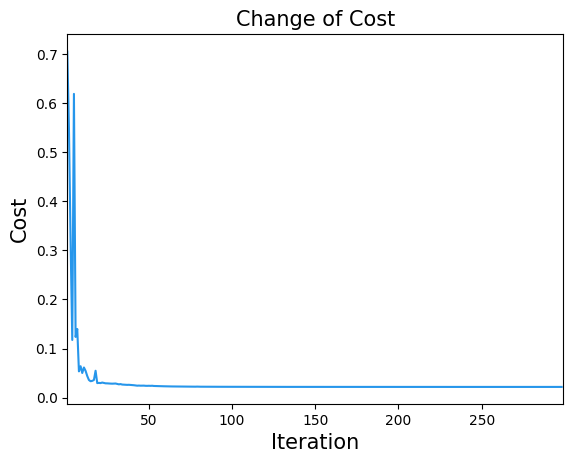

In [8]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [9]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]
qaoa_counts.get_counts()

{'001': 253, '000': 584, '100': 125, '101': 36, '010': 1, '011': 1}

### 6. Decode the Result

After running the quantum circuit, decode the result to obtain the solution.

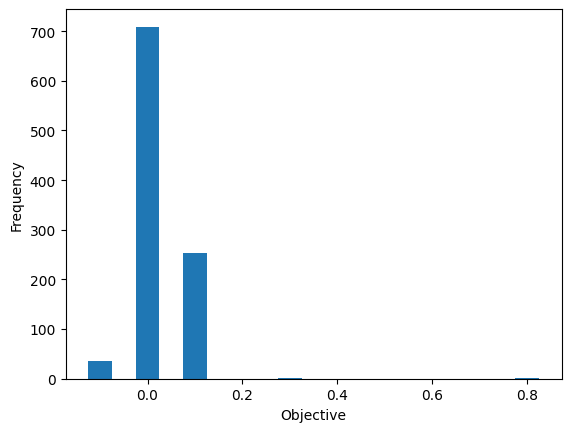

In [10]:
from collections import defaultdict
import matplotlib.pyplot as plt

sampleset: ommx.v1.SampleSet = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
energies = []
energy_freq = defaultdict(int)
for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy = sample.objective
    energies.append(energy)
    energy_freq[energy] += 1
    

plt.bar(energy_freq.keys(), energy_freq.values(), width=0.05)
plt.xlabel('Objective')
plt.ylabel('Frequency')
plt.show()